# ML - Homework 3

**Author: Marusic Diana (331)**

## Task 1

The task 1 consists in recognizing a number with multiple digits from an image.

A convolutional neural network will be used to solve this task.

First of all, the image will be segmented in individual digits, then a neural network will be trained to recognize digits and then the number will be reconstructed.

### Import libraries

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import cv2

from skimage import data
from skimage import filters
from skimage import measure
import math
from skimage import exposure

from random import seed
from random import randint
from numpy import array
from math import ceil
from math import log10
from math import sqrt
from numpy import argmax
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import pad_sequences


from data_generator import training_generator,test_generator


### Initialize constants

In [0]:
FIRST_MODEL_NAME = 'Digits_recog_mode_final.h5'
SECOND_MODEL_NAME = 'sum_digits_RNN_final.h5'

## Generate training samples

In [0]:
NR_SAMPLES = 10000
generator = training_generator(batch_size=NR_SAMPLES) # batch size of 8

x, numbers, numbers_sum = next(generator)

In [57]:
print(numbers[0:3])
print(numbers_sum[0:3])
# print(x[0:3])
print(x.shape)

[[141  13]
 [178  28]
 [ 18  73]]
[[154]
 [206]
 [ 91]]
(10000, 2, 28, 84)


### Plot generated images

Show some of the generated examples from the training set

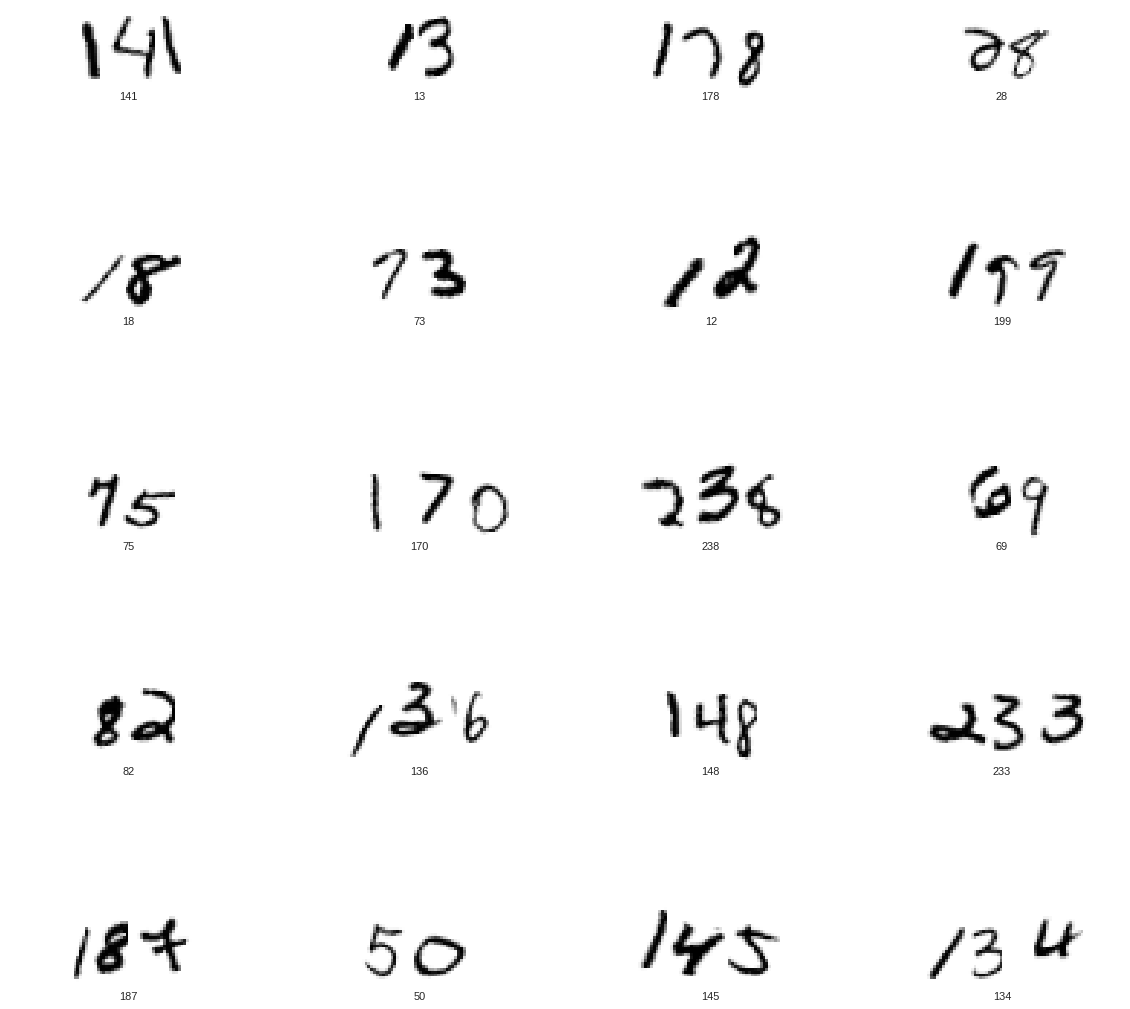

In [58]:

x_train = x
y_train = numbers


plt.figure(figsize=(20,20))
nr = 0

for i in range(min(len(y_train),10)):
  for j in range(2):
    plt.subplot(5,4,nr+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i][j])    
    plt.xlabel(y_train[i][j])
    nr+=1


### Separate columns

Separate columns (first column of numbers and second column of numbers)

In [0]:
def separate_columns(X, numbers):
  X_first = X[:,:1]
  X_second = X[:,1:]
  numbers_first = numbers[:,:1]
  numbers_second = numbers[:,1:]
  
  return X_first, X_second, numbers_first, numbers_second
  

In [60]:

x_first, x_second, numbers_first, numbers_second = separate_columns(x, numbers)

print("First column of numbers:")
print(numbers_first[0:3])
# print(x_first[0:3])
print("x_first shape:")
print(x_first.shape)

print("Second column of numbers:")
print(numbers_second[0:3])
# print(x_second[0:3])
print("x_second shape:")
print(x_second.shape)



First column of numbers:
[[141]
 [178]
 [ 18]]
x_first shape:
(10000, 1, 28, 84)
Second column of numbers:
[[13]
 [28]
 [73]]
x_second shape:
(10000, 1, 28, 84)


In [0]:
# print(x_first[0])
# print(x[0])
x_first = x_first.reshape((NR_SAMPLES,28,84))


### Function to return number of digits in an integer

In [0]:

def nrOfDigits(n):
  if n<10:
    return 1
  return int(math.log10(n))+1


### Digits segmentation

The skimage library with gaussian filter and measure.label function will be used to separate "blocks" of image pixels as individual digits.

First, we will search for the sigma parameter for the Gaussian filter (which determines the "thickness" of the digit).  

We will count the number and percentage of correct segmented images in individual digits and choose the best value for sigma.

[0 1 2 3]
141
3
28
Correct!


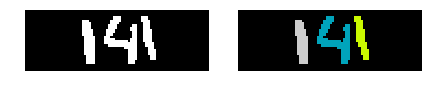

[0 1 2 3]
178
3
28
Correct!


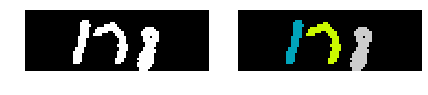

[0 1 2]
18
2
28
Correct!


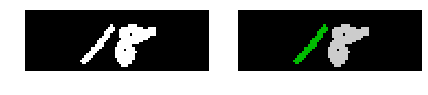

[0 1 2]
12
2
28
Correct!


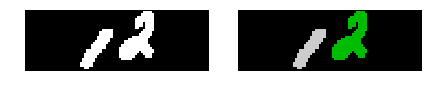

[0 1 2]
75
2
28
Correct!


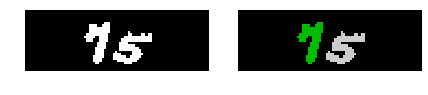

[0 1 2 3]
238
3
28
Correct!


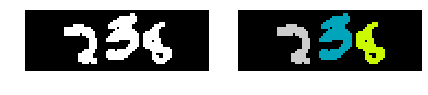

[0 1 2]
82
2
28
Correct!


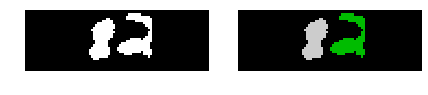

[0 1 2 3]
148
3
28
Correct!


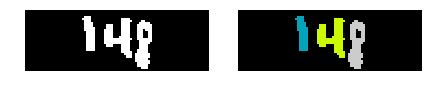

[0 1 2 3]
187
3
28
Correct!


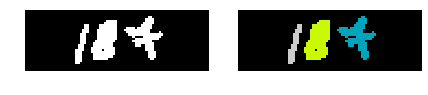

[0 1 2 3]
145
3
28
Correct!


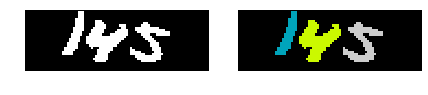

[0 1 2 3]
147
3
28
Correct!


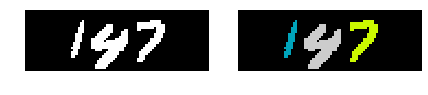

[0 1 2]
212
3
28
Wrong!


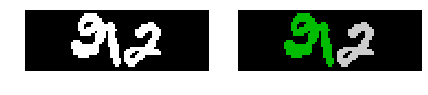

[0 1 2]
73
2
28
Correct!


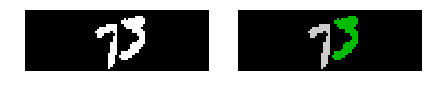

[0 1 2]
24
2
28
Correct!


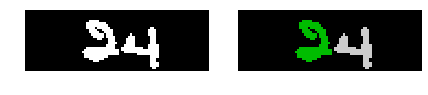

[0 1 2 3 4]
215
3
28
Wrong!


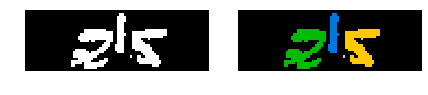

[0 1]
34
2
28
Wrong!


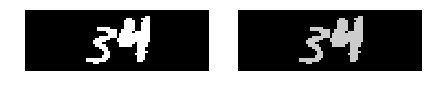

[0 1 2]
14
2
28
Correct!


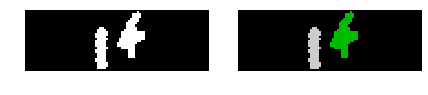

[0 1]
9
1
28
Correct!


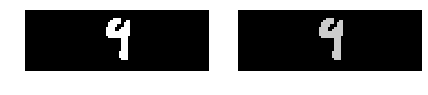

[0 1 2]
26
2
28
Correct!


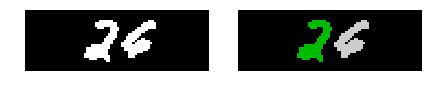

[0 1 2 3]
149
3
28
Correct!


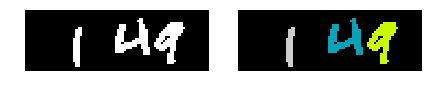

Correct segmented numbers:
17 out of 20
0.85 %
[0 1 2 3]
141
3
28
Correct!


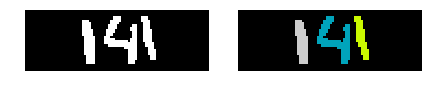

[0 1 2 3]
178
3
28
Correct!


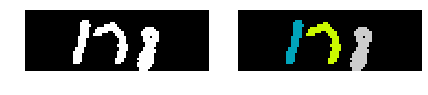

[0 1 2]
18
2
28
Correct!


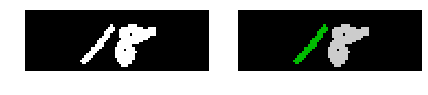

[0 1 2]
12
2
28
Correct!


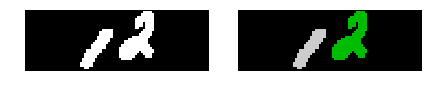

[0 1 2]
75
2
28
Correct!


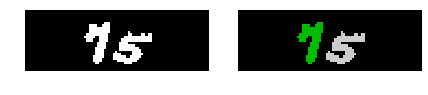

[0 1 2 3]
238
3
28
Correct!


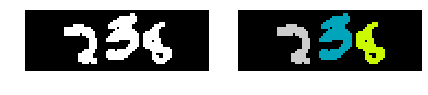

[0 1 2]
82
2
28
Correct!


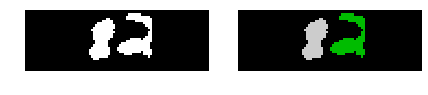

[0 1 2 3]
148
3
28
Correct!


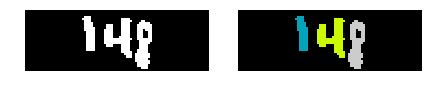

[0 1 2 3]
187
3
28
Correct!


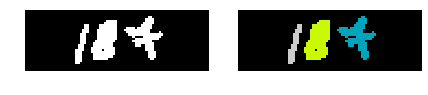

[0 1 2 3]
145
3
28
Correct!


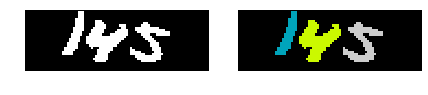

[0 1 2 3]
147
3
28
Correct!


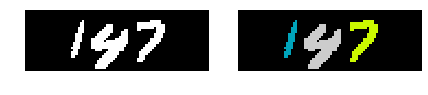

[0 1 2]
212
3
28
Wrong!


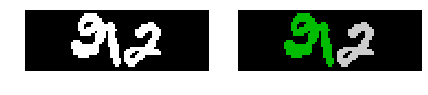

[0 1 2]
73
2
28
Correct!


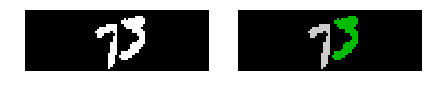

[0 1 2]
24
2
28
Correct!


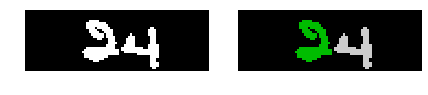

[0 1 2 3 4]
215
3
28
Wrong!


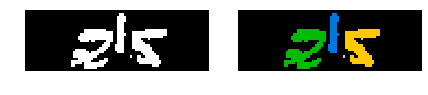

[0 1]
34
2
28
Wrong!


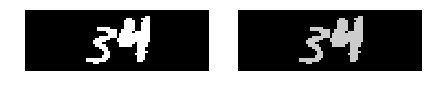

[0 1 2]
14
2
28
Correct!


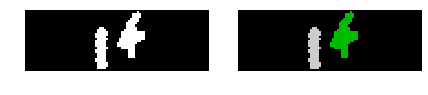

[0 1]
9
1
28
Correct!


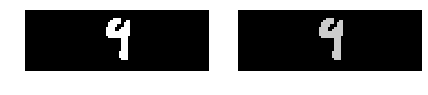

[0 1 2]
26
2
28
Correct!


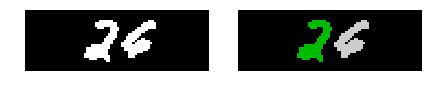

[0 1 2 3]
149
3
28
Correct!


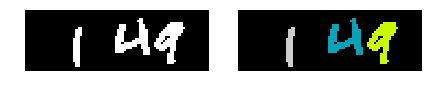

Correct segmented numbers:
17 out of 20
0.85 %
[0 1 2 3]
141
3
28
Correct!


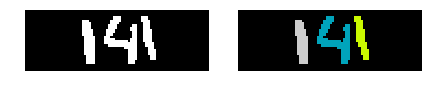

[0 1 2 3]
178
3
28
Correct!


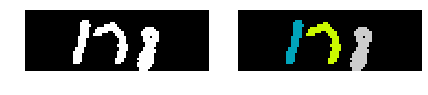

[0 1 2]
18
2
28
Correct!


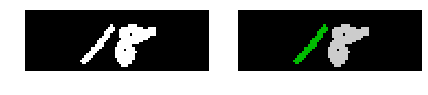

[0 1 2]
12
2
28
Correct!


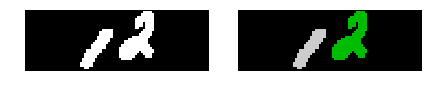

[0 1 2]
75
2
28
Correct!


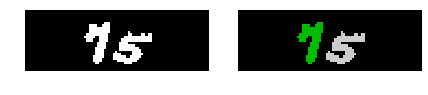

[0 1 2 3]
238
3
28
Correct!


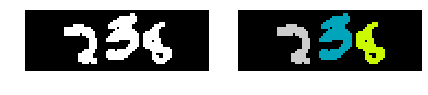

[0 1 2]
82
2
28
Correct!


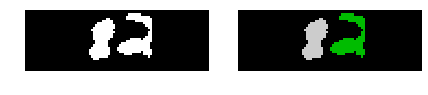

[0 1 2 3]
148
3
28
Correct!


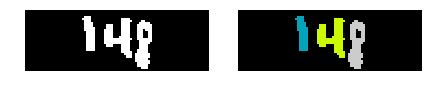

[0 1 2 3]
187
3
28
Correct!


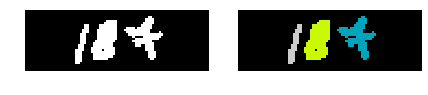

[0 1 2 3]
145
3
28
Correct!


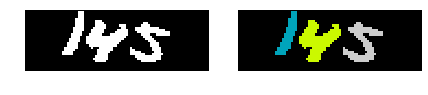

[0 1 2 3]
147
3
28
Correct!


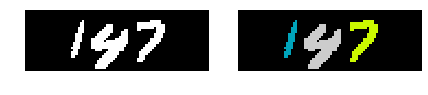

[0 1 2]
212
3
28
Wrong!


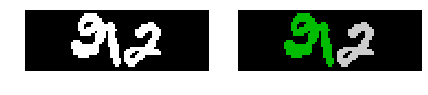

[0 1 2]
73
2
28
Correct!


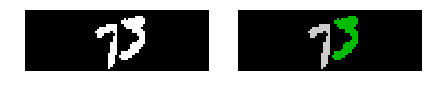

[0 1 2]
24
2
28
Correct!


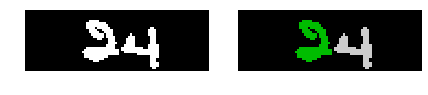

[0 1 2 3 4]
215
3
28
Wrong!


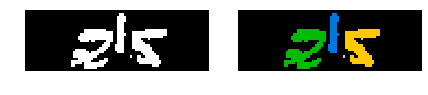

[0 1]
34
2
28
Wrong!


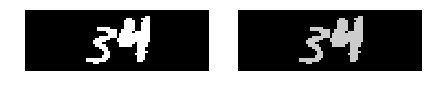

[0 1 2]
14
2
28
Correct!


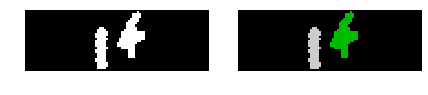

[0 1]
9
1
28
Correct!


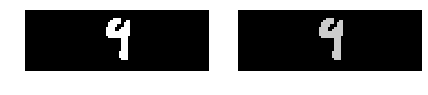

[0 1 2]
26
2
28
Correct!


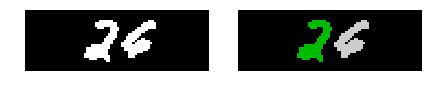

[0 1 2 3]
149
3
28
Correct!


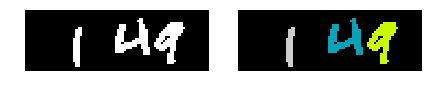

Correct segmented numbers:
17 out of 20
0.85 %
[0 1 2 3]
141
3
28
Correct!


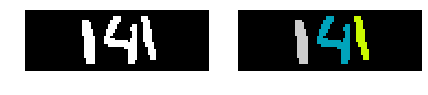

[0 1 2 3]
178
3
28
Correct!


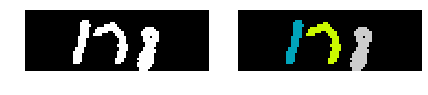

[0 1 2]
18
2
28
Correct!


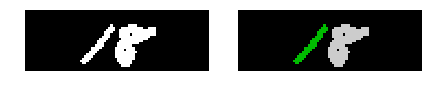

[0 1 2]
12
2
28
Correct!


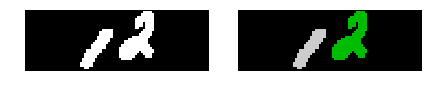

[0 1 2]
75
2
28
Correct!


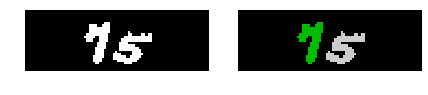

[0 1 2 3]
238
3
28
Correct!


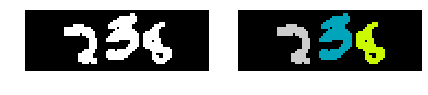

[0 1 2]
82
2
28
Correct!


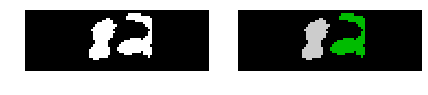

[0 1 2 3]
148
3
28
Correct!


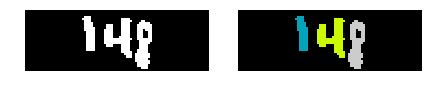

[0 1 2 3]
187
3
28
Correct!


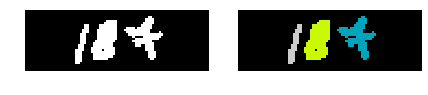

[0 1 2 3]
145
3
28
Correct!


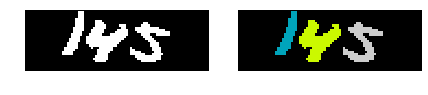

[0 1 2 3]
147
3
28
Correct!


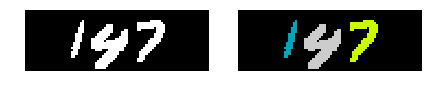

[0 1 2]
212
3
28
Wrong!


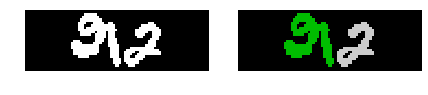

[0 1 2]
73
2
28
Correct!


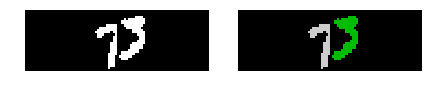

[0 1 2]
24
2
28
Correct!


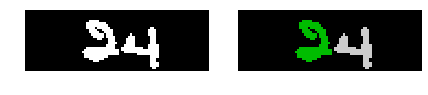

[0 1 2 3 4]
215
3
28
Wrong!


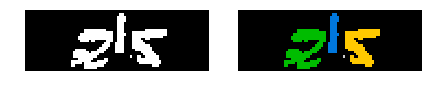

[0 1]
34
2
28
Wrong!


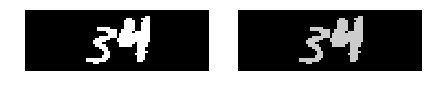

[0 1 2]
14
2
28
Correct!


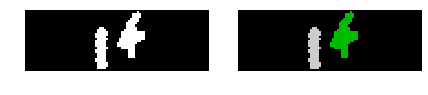

[0 1]
9
1
28
Correct!


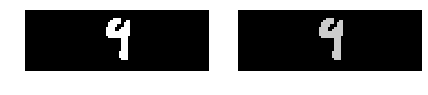

[0 1 2]
26
2
28
Correct!


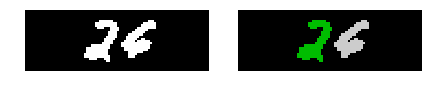

[0 1 2 3]
149
3
28
Correct!


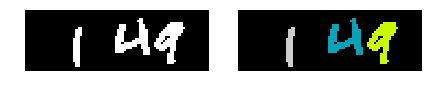

Correct segmented numbers:
17 out of 20
0.85 %
[0 1 2 3]
141
3
28
Correct!


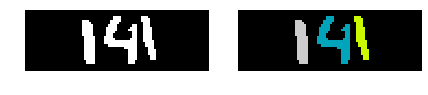

[0 1 2 3]
178
3
28
Correct!


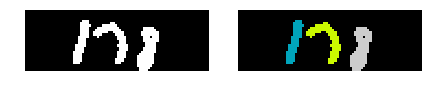

[0 1 2]
18
2
28
Correct!


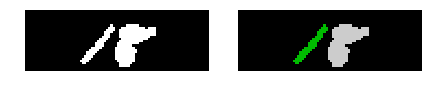

[0 1 2]
12
2
28
Correct!


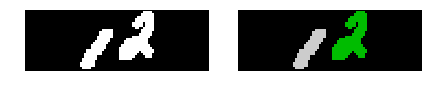

[0 1 2]
75
2
28
Correct!


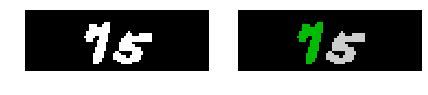

[0 1 2]
238
3
28
Wrong!


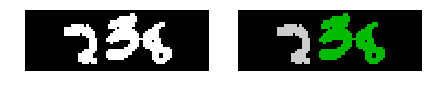

[0 1 2]
82
2
28
Correct!


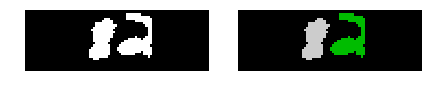

[0 1 2 3]
148
3
28
Correct!


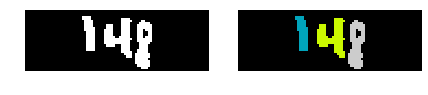

[0 1 2 3]
187
3
28
Correct!


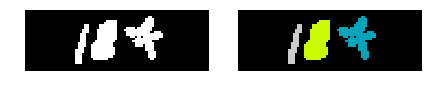

[0 1 2 3]
145
3
28
Correct!


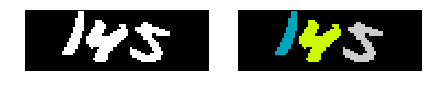

[0 1 2 3]
147
3
28
Correct!


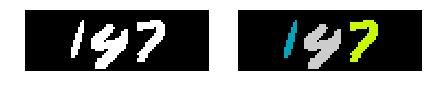

[0 1 2]
212
3
28
Wrong!


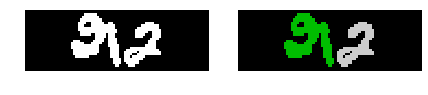

[0 1 2]
73
2
28
Correct!


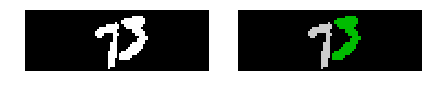

[0 1 2]
24
2
28
Correct!


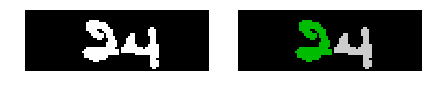

[0 1 2 3 4]
215
3
28
Wrong!


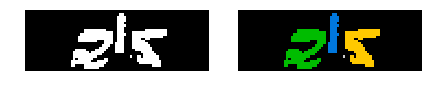

[0 1]
34
2
28
Wrong!


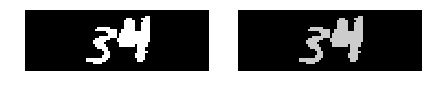

[0 1 2]
14
2
28
Correct!


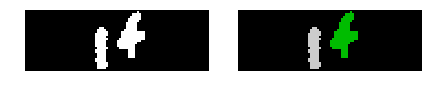

[0 1]
9
1
28
Correct!


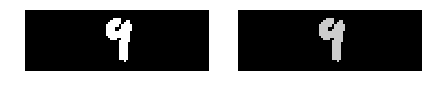

[0 1 2]
26
2
28
Correct!


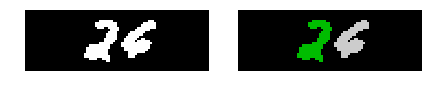

[0 1 2 3]
149
3
28
Correct!


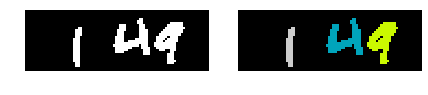

Correct segmented numbers:
16 out of 20
0.8 %
[0 1 2 3]
141
3
28
Correct!


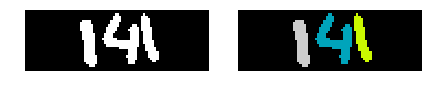

[0 1 2 3]
178
3
28
Correct!


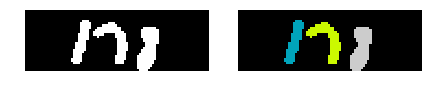

[0 1 2]
18
2
28
Correct!


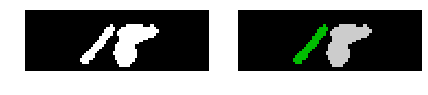

[0 1 2]
12
2
28
Correct!


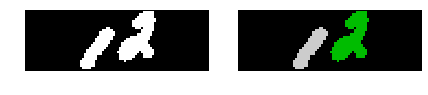

[0 1 2]
75
2
28
Correct!


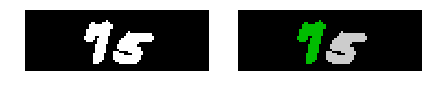

[0 1 2]
238
3
28
Wrong!


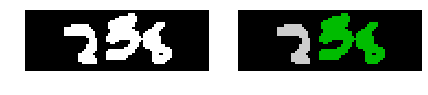

[0 1 2]
82
2
28
Correct!


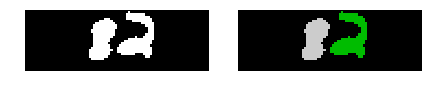

[0 1 2 3]
148
3
28
Correct!


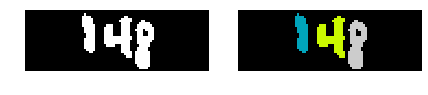

[0 1 2 3]
187
3
28
Correct!


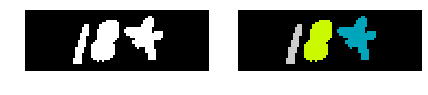

[0 1 2 3]
145
3
28
Correct!


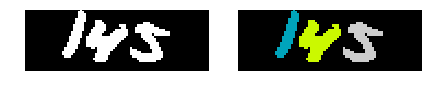

[0 1 2 3]
147
3
28
Correct!


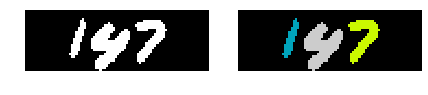

[0 1]
212
3
28
Wrong!


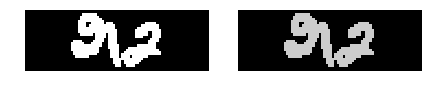

[0 1]
73
2
28
Wrong!


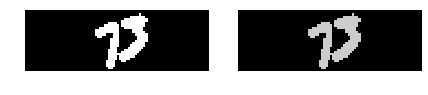

[0 1 2]
24
2
28
Correct!


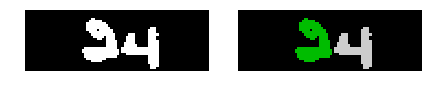

[0 1 2 3 4]
215
3
28
Wrong!


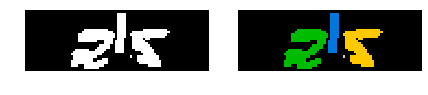

[0 1]
34
2
28
Wrong!


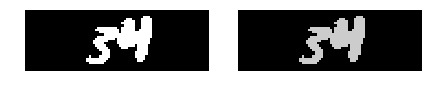

[0 1 2]
14
2
28
Correct!


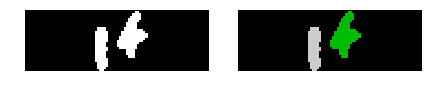

[0 1]
9
1
28
Correct!


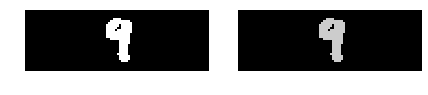

[0 1 2]
26
2
28
Correct!


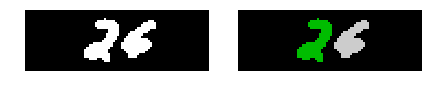

[0 1 2 3]
149
3
28
Correct!


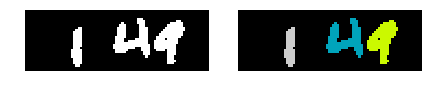

Correct segmented numbers:
15 out of 20
0.75 %
[0 1 2 3]
141
3
28
Correct!


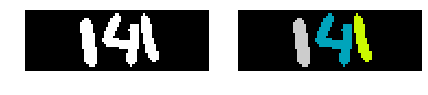

[0 1 2 3]
178
3
28
Correct!


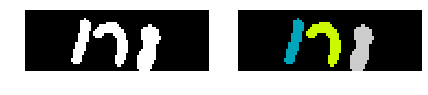

[0 1 2]
18
2
28
Correct!


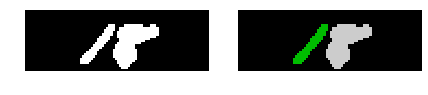

[0 1 2]
12
2
28
Correct!


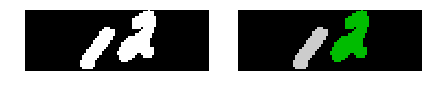

[0 1 2]
75
2
28
Correct!


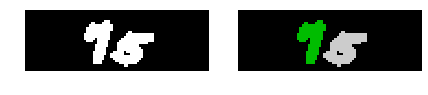

[0 1 2]
238
3
28
Wrong!


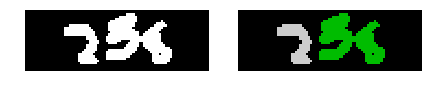

[0 1 2]
82
2
28
Correct!


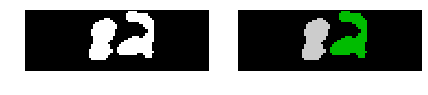

[0 1 2]
148
3
28
Wrong!


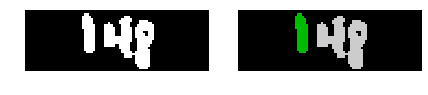

[0 1 2 3]
187
3
28
Correct!


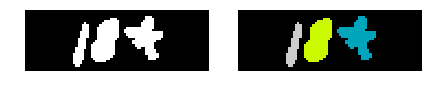

[0 1 2 3]
145
3
28
Correct!


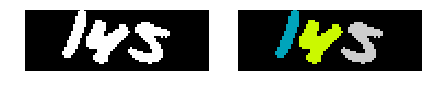

[0 1 2 3]
147
3
28
Correct!


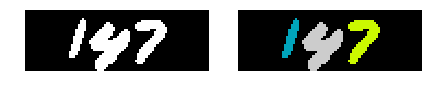

[0 1]
212
3
28
Wrong!


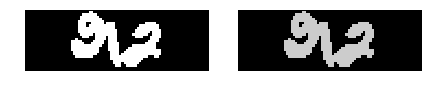

[0 1]
73
2
28
Wrong!


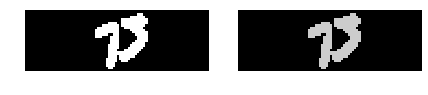

[0 1 2]
24
2
28
Correct!


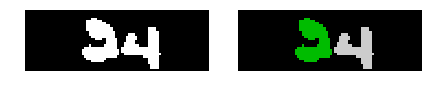

[0 1 2 3]
215
3
28
Correct!


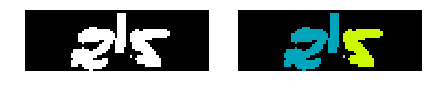

[0 1]
34
2
28
Wrong!


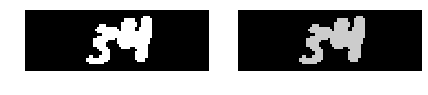

[0 1 2]
14
2
28
Correct!


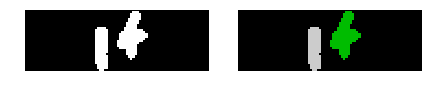

[0 1]
9
1
28
Correct!


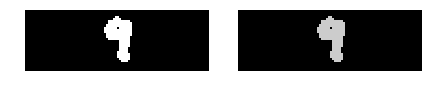

[0 1 2]
26
2
28
Correct!


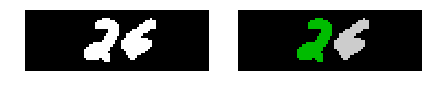

[0 1 2 3]
149
3
28
Correct!


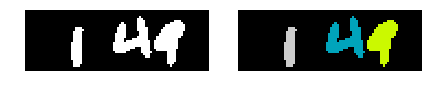

Correct segmented numbers:
15 out of 20
0.75 %


In [63]:
nr_correct_segments = []
percentage_segments = []

sigma_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for sigma in sigma_values:

  nr_correct_segment = 0

  array_of_images = x_first[0:20]

  for (idx, im) in enumerate(array_of_images):
    im = filters.gaussian(im, sigma=sigma)

    blobs = im > 0.7 * im.mean()

    all_labels = measure.label(blobs)
    blobs_labels = measure.label(blobs, background=0)
    print(np.unique(blobs_labels))
    print(y_train[idx][0])
    nr_digits = nrOfDigits(y_train[idx][0])
    print(nr_digits)
    print(len(blobs_labels))

    if len(np.unique(blobs_labels)) == nr_digits+1:
      print("Correct!")
      nr_correct_segment += 1
    else:
      print("Wrong!")

    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(blobs, cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(blobs_labels, cmap='nipy_spectral')
    plt.axis('off')
#     plt.subplot(133)
#     plt.imshow(blobs_labels, cmap='hot')
#     plt.axis('off')

    plt.tight_layout()
    plt.show()

  print("Correct segmented numbers:")
  print(nr_correct_segment, 'out of', len(array_of_images))
  percentage_segment = (0.0+nr_correct_segment)/len(array_of_images)
  print(percentage_segment, '%')
  
  nr_correct_segments.append(nr_correct_segment)
  percentage_segments.append(percentage_segment)



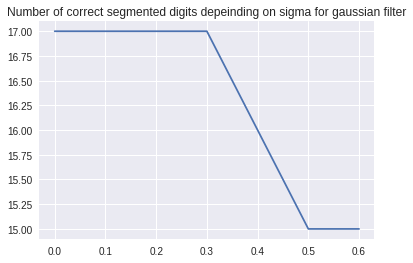

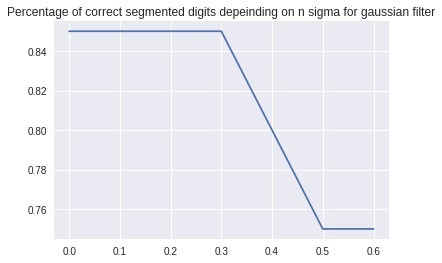

In [64]:
plt.plot(sigma_values, nr_correct_segments)
plt.title("Number of correct segmented digits depeinding on sigma for gaussian filter")
plt.show()

plt.plot(sigma_values, percentage_segments)
plt.title("Percentage of correct segmented digits depeinding on n sigma for gaussian filter")
plt.show()

#### Conclusion:
The smaller the sigma, the "thinner"  are the digits and the better is the segmentation.
So the value of **sigma=0.1** will be used next

## Create a function to segment digits, using the best sigma parameter identified

The function will also return a boolean value representing if the number was segmented correct or not (based only on number of digits, not on the actual value of digit).

In [0]:
def segment_image(im, number):

  correct_segmentation = False
  
  sigma=0.1
  
  im = filters.gaussian(im, sigma=sigma)
  blobs = im > 0.9 * im.mean()

  blobs_labels = measure.label(blobs, background=0)
  distinct_labels = np.unique(blobs_labels)
  
  print(distinct_labels)
  print(number)
  nr_digits = nrOfDigits(number)
  print(nr_digits)
  print(len(blobs_labels))

  if len(distinct_labels) == nr_digits+1:
    print("Correct!")
    correct_segmentation = True
  else:
    print("Wrong!")

  plt.figure(figsize=(9, 3.5))
  plt.subplot(131)
  plt.imshow(blobs, cmap='gray')
  plt.axis('off')
  plt.subplot(132)
  plt.imshow(blobs_labels, cmap='nipy_spectral')
  plt.axis('off')
  plt.subplot(133)
  plt.imshow(blobs_labels, cmap='hot')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

  image_digits = []
  
  for (i,label) in enumerate(distinct_labels[1:]):
    image_digit = np.where(blobs_labels==label, blobs_labels, 0)
    image_digits.append(image_digit)
    
  
  return image_digits, correct_segmentation
  
  
  
  

Let's run the function on one number and show results.

[0 1 2 3]
[178]
3
28
Correct!


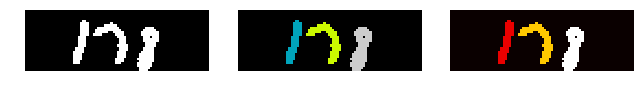

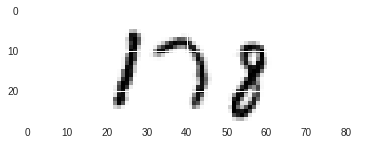

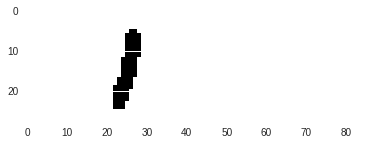

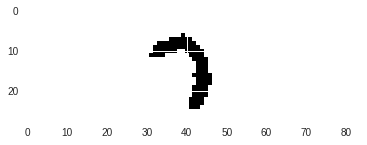

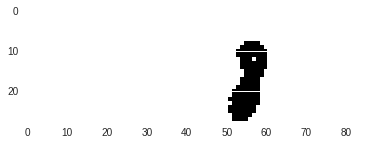

Is segmentation correct? True


In [66]:
image_digits, correct_segmentation = segment_image(x_first[1], numbers_first[1])

plt.imshow(x_first[1])
plt.show()
  
for image_digit in image_digits:
    plt.imshow(image_digit)
    plt.show()

print("Is segmentation correct?", correct_segmentation)
    

### Use a version of the segment image function with transposed images to identify digits in the correct order of their appearance (from left to right)

The function for image segmentation finds digits from top to bottom in the current version. But we need to know the exact order of apparition of digits (from left to right). That's why we change the function segment_image in the following way:

- first, we transpose the initial image. Now the segmentation from top to bottom will mean separating digits from left to right
- second, the  returned digit images will be also transposed, to return to the normal format 

In [0]:
def segment_image_transpose(im, number, train=True, plot=True, verbose=True):
  
  correct_segmentation = False
  sigma = 0.1

  nr_correct_segment = 0
  
  im = np.transpose(im)
  
  im = filters.gaussian(im, sigma=sigma)
  blobs = im > 0.7 * im.mean()

  blobs_labels = measure.label(blobs, background=0)
  distinct_labels = np.unique(blobs_labels)
  
  if verbose:
    print(distinct_labels)
    print(number)
  
  nr_digits = nrOfDigits(number)

  if verbose:
    print(nr_digits)
    print(len(blobs_labels))

  if len(distinct_labels) == nr_digits+1:
    if verbose:
      print("Correct!")
    correct_segmentation = True
  else:
    if verbose:
      print("Wrong!")

  if plot:
    plt.figure(figsize=(9, 3.5))
    plt.subplot(131)
    plt.imshow(np.transpose(blobs), cmap='gray')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(np.transpose(blobs_labels), cmap='nipy_spectral')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(np.transpose(blobs_labels), cmap='hot')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

  image_digits = []
  
  for (i,label) in enumerate(distinct_labels[1:]):
    image_digit = np.where(blobs_labels==label, blobs_labels, 0)
    image_digits.append(np.transpose(image_digit))
    
  
  return image_digits, correct_segmentation
  
  
  
  

[0 1 2 3]
[178]
3
84
Correct!


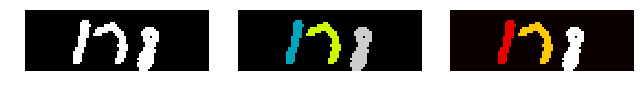

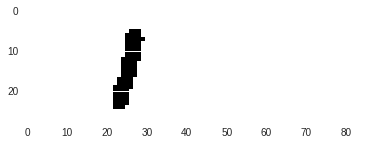

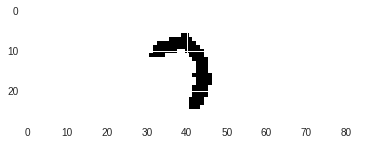

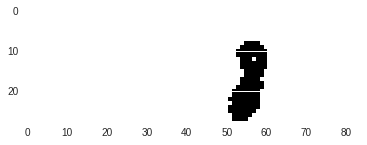

Is segmentation correct? True


In [68]:
image_digits, correct_segmentation = segment_image_transpose(x_first[1], numbers_first[1])

for image_digit in image_digits:
    plt.imshow(image_digit)
    plt.show()
    
print("Is segmentation correct?", correct_segmentation)


In [0]:
def segment_image_transpose_test(im):
  sigma = 0.33

  nr_correct_segment = 0
  
  im = np.transpose(im)
  
  im = filters.gaussian(im, sigma=sigma)
  blobs = im > 0.7 * im.mean()

  blobs_labels = measure.label(blobs, background=0)
  distinct_labels = np.unique(blobs_labels)
  
  image_digits = []
  
  for (i,label) in enumerate(distinct_labels[1:]):
    image_digit = np.where(blobs_labels==label, blobs_labels, 0)
    image_digits.append(np.transpose(image_digit))
    
  
  return image_digits  
  

In [0]:
def separate_nr_digits(number):
   return [int(i) for i in str(number)]  

In [71]:
print(numbers_first.shape)
numbers_first = numbers_first.flatten()
print(numbers_first.shape)

(10000, 1)
(10000,)


In [72]:
print(numbers_second.shape)
numbers_second = numbers_second.flatten()
print(numbers_second.shape)

(10000, 1)
(10000,)


In [73]:
x_train_first = np.empty((1,28,84))
labels_first = np.empty(1)

for i in range (1,NR_SAMPLES):
  number_digits = separate_nr_digits(numbers_first[i])
  
  image_digits, correct_segmentation = segment_image_transpose(x_first[i], numbers_first[i], plot=False, verbose=False)
    
  if correct_segmentation:
    for image in image_digits:
      x_train_first = np.append(x_train_first, image.reshape(1,28,84), axis=0)  
    labels_first = np.append(labels_first,number_digits)
    
#   for image_digit in image_digits:
#       plt.imshow(image_digit)
#       plt.show()
  
print(numbers_first[i])
print(number_digits)  
print(x_train_first.shape)
print(labels_first)


136
[1, 3, 6]
(22071, 28, 84)
[4. 1. 7. ... 1. 3. 6.]


Show and evaluate the results for the first 10 examples:

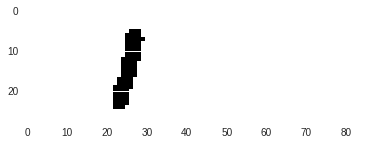

1.0


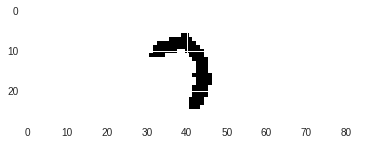

7.0


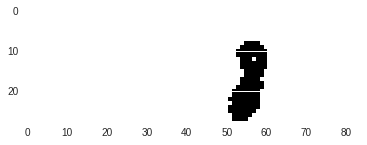

8.0


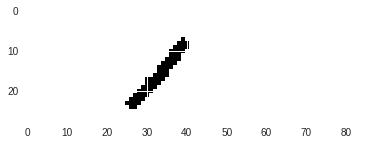

1.0


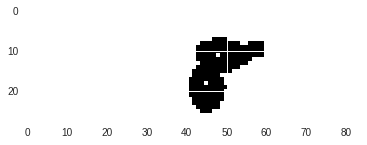

8.0


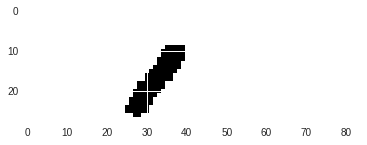

1.0


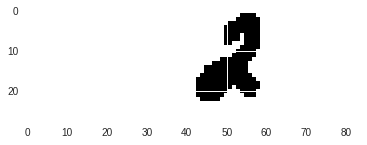

2.0


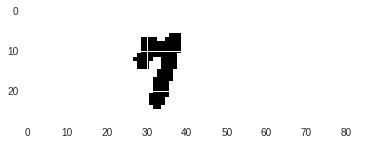

7.0


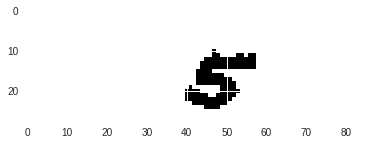

5.0


In [74]:
for i in range(1,10):
  plt.imshow(x_train_first[i])
  plt.show()
  print(labels_first[i])  

Segmentation is correct

### Build the neural network model

In [75]:
x_train_first
print(x_train_first.shape)
# x_train_first = x_train_first.reshape()

labels_first
# x_train_first = np.expand_dims(x_train_first, 0)
# x_test = np.expand_dims(x_test, -1)

x_train_first = x_train_first.reshape(len(labels_first),1,28,84)
print(x_train_first.shape)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=(1,28,84), activation='relu', padding='same'))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# model.summary()

(22071, 28, 84)
(22071, 1, 28, 84)


In [76]:
model.fit(x_train_first, labels_first, epochs=30)
# model.evaluate(x_test, y_test)

Epoch 1/30
22071/22071 [==============================] - 5s 223us/step - loss: 1.8535 - acc: 0.3623
Epoch 2/30
22071/22071 [==============================] - 3s 135us/step - loss: 1.3113 - acc: 0.5419
Epoch 3/30
22071/22071 [==============================] - 3s 135us/step - loss: 1.1562 - acc: 0.5967
Epoch 4/30
22071/22071 [==============================] - 3s 136us/step - loss: 1.0054 - acc: 0.6639
Epoch 5/30
22071/22071 [==============================] - 3s 137us/step - loss: 0.8657 - acc: 0.7213
Epoch 6/30
22071/22071 [==============================] - 3s 136us/step - loss: 0.7634 - acc: 0.7609
Epoch 7/30
22071/22071 [==============================] - 3s 136us/step - loss: 0.6840 - acc: 0.7884
Epoch 8/30
22071/22071 [==============================] - 3s 136us/step - loss: 0.6271 - acc: 0.8040
Epoch 9/30
22071/22071 [==============================] - 3s 136us/step - loss: 0.5862 - acc: 0.8169
Epoch 10/30
22071/22071 [==============================] - 3s 136us/step - loss: 0.5566 - a

### Save model

In [78]:
from keras.models import load_model

model.summary()
model.save(FIRST_MODEL_NAME)  # creates a HDF5 file 'my_model.h5'

# Forloading model:
# model = load_model('RNN_sum_model.h5')
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 28, 32)         24224     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 28, 32)         9248      
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                8970      
Total params: 42,442
Trainable params: 42,442
Non-trainable params: 0
_________________________________________________________________


### Evaluate model performance on second column of integers

In [80]:

x_train_test = np.empty((0,28,84))
labels_second = np.empty(0)
nr_images = 0

print(x_second.shape)

x_second = x_second.reshape(NR_SAMPLES, 28,84)

for (idx, image) in enumerate(x_second[0:100]):
 
  number_digits = separate_nr_digits(numbers_second[idx])
  
  labels_second = np.append(labels_second,number_digits)
#   plt.imshow(image)
#   plt.show()
#   print(labels_second)
#   print(labels_second.shape)
  
#   print(number_digits)
  
  image_digits, correct_segm = segment_image_transpose(image, numbers_second[idx], plot=False, verbose=False)
  
  nr_images_current = 0
  
  for image_digit in image_digits:
#       plt.imshow(image_digit)
#       plt.show()
      nr_images += 1
      nr_images_current += 1
      
      x_train_test = np.append(x_train_test, image_digit.reshape(1,28,84), axis=0)  
  

#   In case digits were not separated properly:
  diff_length = len(number_digits) - len(image_digits)
  if (diff_length>0):
    x_train_test = np.append(x_train_test, np.zeros((1,28,84))*diff_length, axis=0)
  elif (diff_length<0):
    #   if more numbers in images than digits, add digits in labels
    labels_second = np.append(labels_second, np.zeros(1)*diff_length, axis=0)
    
    
nr_images = len(labels_second)

print(x_train_test.shape)
print(nr_images)
# print(x_train_test[0])
x_train_test = x_train_test.reshape(nr_images,1,28,84)


prediction = np.round(model.predict(x_train_test))


model.evaluate(x_train_test, labels_second[0:nr_images].astype(int))



(10000, 28, 84)
(256, 28, 84)
256
256/256 [==============================] - 1s 3ms/step


[0.957564651966095, 0.796875]

In [81]:
print("predicted : actual")
for (i,predicted) in enumerate(prediction):
  print(argmax(predicted), " : ", labels_second[i].astype(int))
  

predicted : actual
1  :  1
3  :  3
0  :  2
0  :  8
7  :  7
3  :  3
1  :  1
7  :  9
9  :  9
1  :  1
7  :  7
0  :  0
0  :  6
9  :  9
1  :  1
2  :  3
6  :  6
6  :  0
2  :  2
3  :  3
3  :  3
5  :  5
0  :  0
1  :  1
3  :  3
4  :  4
1  :  1
4  :  4
2  :  2
9  :  4
9  :  9
2  :  2
3  :  3
6  :  6
1  :  1
7  :  3
7  :  7
4  :  4
6  :  6
2  :  4
0  :  3
6  :  6
0  :  2
1  :  1
4  :  4
0  :  0
3  :  3
0  :  3
5  :  6
2  :  2
1  :  1
2  :  2
1  :  1
1  :  1
6  :  6
3  :  3
2  :  2
2  :  2
8  :  8
1  :  1
0  :  0
5  :  5
2  :  2
2  :  2
2  :  3
0  :  0
1  :  1
9  :  9
2  :  2
1  :  1
7  :  7
0  :  4
2  :  2
1  :  1
5  :  7
1  :  0
0  :  8
1  :  1
1  :  1
1  :  1
1  :  1
0  :  0
4  :  4
1  :  1
0  :  0
0  :  1
4  :  4
7  :  7
2  :  2
3  :  3
2  :  2
1  :  1
3  :  3
3  :  3
1  :  1
4  :  9
0  :  4
4  :  0
2  :  2
2  :  2
1  :  4
5  :  5
0  :  2
3  :  3
1  :  1
7  :  1
5  :  7
0  :  5
2  :  2
0  :  4
1  :  1
6  :  6
6  :  6
1  :  1
4  :  4
0  :  0
2  :  2
3  :  3
5  :  5
0  :  4
1  :  1
3  :  3
2  : 

### Use the function test_generator to test on the test set and evaluate performance on full numbers

In [0]:
NR_SAMPLES = 3000
generator_test = test_generator(batch_size=NR_SAMPLES) 

x_test, numbers_test, numbers_sum_test = next(generator_test)

In [0]:
 
x_first_test, x_second_test, numbers_first_test, numbers_second_test = separate_columns(x_test, numbers_test)

In [84]:
# model = tf.keras.models.load_model('Digits_recog_model1_30epoch.h5')

model = tf.keras.models.load_model(FIRST_MODEL_NAME)

# x_train_test = np.empty((1,28,84))
labels_first_test = np.empty(0)
nr_images = 0


nr_corect_predicted = 0;

print(x_first_test.shape)

x_first_test = x_first_test.reshape(NR_SAMPLES, 28,84).astype(int)

for (idx, image) in enumerate(x_first_test):
  x_train_test = np.empty((0,28,84))
  labels_first_test = np.empty(0)
  

  correct_predicted_current = True
  
  print(numbers_first_test[idx])
  number_digits = separate_nr_digits(int(numbers_first_test[idx]))
  
  labels_first_test = np.append(labels_first_test,number_digits)
  
  image_digits, correct_segm = segment_image_transpose(image, numbers_first_test[idx], plot=False, verbose=False)
  
  nr_images_current = 0
  
  
  
  
  for image_digit in image_digits:
#       plt.imshow(image_digit)
#       plt.show()
      nr_images += 1
      nr_images_current += 1
      
      x_train_test = np.append(x_train_test, image_digit.reshape(1,28,84), axis=0)  
#       x_train_test[0] = image_digit.reshape(1,28,84)  
  

#   In case digits were not separated properly:
  diff_length = len(number_digits) - len(image_digits)
  if (diff_length>0):
    x_train_test = np.append(x_train_test, np.zeros((1,28,84))*diff_length, axis=0)
  elif (diff_length<0):
    #   if more numbers in images than digits, add digits in labels
    labels_first_test = np.append(labels_first_test, np.zeros(1)*diff_length, axis=0)
  
#   print("Len number digits", len(number_digits))
  
#   print("Len image digits", len(image_digits))
# nr_images = len(labels_first_test)
# 
#   print(x_train_test.shape)
# print(nr_images)
# print(x_train_test[0])
#   x_train_test = x_train_test.reshape(nr_images,1,28,84)
#   x_train_test = x_train_test.reshape(max(len(image_digits), len(number_digits)),1,28,84)

  x_train_test = np.expand_dims(x_train_test, axis=1)



  prediction = np.round(model.predict(x_train_test))
  
  print("predicted : actual")
  
  for (i,predicted) in enumerate(prediction):
    predicted_label = argmax(predicted)
      
    if i<3:
#       print("i::", i)

#       print("Labels first test[i]:", labels_first_test[i])
      actual_label = labels_first_test[i].astype(int)
      print(predicted_label, " : ", actual_label)
      if predicted_label != actual_label:
        correct_predicted_current = False
    else:
      print(predicted_label, " : -")
      correct_predicted_current = False
      
  if correct_predicted_current:
    nr_corect_predicted += 1
  print("-------------------")
# model.evaluate(x_train_test, labels_first_test[0:nr_images].astype(int))

print("Number of correct predicted examples is ", nr_corect_predicted, " out of ", NR_SAMPLES)



(3000, 1, 28, 84)
[112]


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


predicted : actual
1  :  1
1  :  1
0  :  2
-------------------
[117]
predicted : actual
1  :  1
1  :  1
7  :  7
-------------------
[106]
predicted : actual
1  :  1
0  :  0
6  :  6
-------------------
[215]
predicted : actual
2  :  2
1  :  1
5  :  5
-------------------
[246]
predicted : actual
2  :  2
2  :  4
6  :  6
-------------------
[88]
predicted : actual
0  :  8
8  :  8
-------------------
[93]
predicted : actual
9  :  9
3  :  3
-------------------
[7]
predicted : actual
7  :  7
-------------------
[123]
predicted : actual
1  :  1
2  :  2
2  :  3
-------------------
[97]
predicted : actual
9  :  9
7  :  7
-------------------
[51]
predicted : actual
5  :  5
1  :  1
-------------------
[135]
predicted : actual
1  :  1
8  :  3
0  :  5
-------------------
[235]
predicted : actual
2  :  2
3  :  3
5  :  5
-------------------
[153]
predicted : actual
5  :  1
3  :  5
0  :  3
-------------------
[115]
predicted : actual
1  :  1
1  :  1
5  :  5
-------------------
[5]
predicted : actual
5 

## Task 2: Addition

Building a recurrent neural network that adds 2 numbers

Strategy: use an encoder-decoder (sequence 2 sequence) model

### Generate dataset or use dataset already generated for task 1

In [0]:
NR_SAMPLES = 10000
generator = training_generator(batch_size=NR_SAMPLES) # batch size of 8

x, numbers, numbers_sum = next(generator)

## Step 1 - Encoding

- First of all, individual digits will be transformed to characters for each number.

*eg. a=123, b=4 will be transformed in '['1', '2', '3'] and ['4']*

- After that, will use padding to obtain arrays of equal size (3 characters); The value of 10 is used for padding, because it will be the 10th character in the alphabet.

*a = ['1','2','3'], b=['10','10','4']*

- After that, digit characters for both numbers will be concatenated.

*['1','2','3',.'10','10','4']*

- And last, will use one hot encoding for encoding.

*[0 1 0 0 0 0 0 0 0 0 0]*

*[0 0 1 0 0 0 0 0 0 0 0]*

*[0 0 0 1 0 0 0 0 0 0 0]*

*[0 0 0 0 0 0 0 0 0 0 1]*

*[0 0 0 0 0 0 0 0 0 0 1]*

*[0 0 0 0 1 0 0 0 0 0 0]*



In [86]:
def encode_numbers(numbers_dataset, is_train=False, max_lenght = 3):
  n = len(numbers_dataset)
#   print(numbers_dataset[0][0])
  X = np.zeros((n, (max_lenght)*2, 11))
  Y = np.zeros((n, max_lenght, 11))
  
  for i in range(n):
    a = numbers_dataset[i][0]
    b = numbers_dataset[i][1]
    
    if(is_train):
      s = a + b
      s = [int(i) for i in str(s)]

    a = [int(i) for i in str(a)]
    b = [int(i) for i in str(b)]
  
    print(a,b)
    
    if is_train:
      a,b,s = pad_sequences([a,b,s],maxlen = max_lenght, value=10)
      x , y = np.concatenate([a,b]), s
    else:
      a,b = pad_sequences([a,b],maxlen = max_lenght, value=10)
      x = np.concatenate([a,b])

    for j, char in enumerate(x):
         X[i, j, char] = 1
     
    if(is_train):
      for j, char in enumerate(s):
         Y[i, j, char] = 1
          
  if(is_train):
      return X, Y
  return X

X , Y = encode_numbers(numbers, True)

# print(numbers[0:10])
# print(X[0:10])
# print(Y[0:10])


[1, 4, 4] [7, 9]
[1, 1, 0] [5]
[1, 1, 0] [1, 0, 9]
[1, 4, 6] [1, 8]
[8, 4] [1, 1, 7]
[1, 9, 9] [2, 3, 2]
[2, 0, 2] [1, 7, 7]
[3, 4] [1, 5, 3]
[6, 4] [8, 3]
[1, 3, 4] [5, 1]
[2, 4, 0] [1, 7, 7]
[2, 5, 0] [6, 0]
[8, 0] [3, 5]
[1, 7, 3] [1, 1, 6]
[2] [1, 3, 8]
[1, 0] [2, 0, 3]
[2, 0, 9] [1, 6]
[2, 2, 4] [1, 3, 3]
[2, 3, 2] [7, 7]
[9, 1] [2, 4, 2]
[2, 0, 8] [1, 2, 7]
[1, 1, 5] [8, 0]
[1, 9, 6] [1, 1, 7]
[1, 0, 4] [1, 0, 3]
[1, 6, 2] [1, 2, 4]
[9, 8] [7, 0]
[6, 8] [9, 0]
[1, 3] [5, 7]
[1, 8, 6] [1, 1, 2]
[1, 6, 8] [4, 9]
[2, 2, 2] [1, 7, 5]
[1, 9, 3] [1, 2, 2]
[2, 2, 3] [2, 2, 6]
[1, 4, 2] [1, 1, 9]
[2, 2, 3] [2, 2, 2]
[9, 0] [1, 6, 0]
[3, 0] [8, 0]
[2, 2, 6] [2, 0, 4]
[1, 6, 8] [7, 2]
[1, 2, 7] [1, 5, 3]
[7, 9] [1, 7, 5]
[1, 7, 2] [1, 3, 9]
[5, 8] [1, 2, 5]
[1, 7, 4] [8, 3]
[1, 6, 5] [1, 0, 4]
[1, 0, 7] [1, 9, 9]
[1, 9] [1, 2, 7]
[2, 2, 5] [9, 9]
[2, 0, 2] [1, 4, 9]
[3, 3] [7, 6]
[4, 6] [2, 7]
[2, 3, 1] [1, 5, 5]
[2, 5, 1] [1, 8, 7]
[1, 0, 3] [1, 9, 9]
[9, 1] [9, 6]
[1, 1, 5] [1, 2, 9]
[2,

### Step2 - Configure network and train model

In [87]:
alphabet = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
chars_len = len(alphabet)

input_len = 6
output_len = 3

model = Sequential()
model.add(LSTM(100, input_shape=(input_len, chars_len)))
model.add(RepeatVector(output_len))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(chars_len, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 3, 11)             561       
Total params: 75,561
Trainable params: 75,561
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
# model.fit(X, Y, epochs=20)
model.fit(X, Y, epochs=100)



Epoch 1/100
10000/10000 [==============================] - 11s 1ms/step - loss: 1.9990 - acc: 0.2431
Epoch 2/100
10000/10000 [==============================] - 9s 851us/step - loss: 1.7677 - acc: 0.3055
Epoch 3/100
10000/10000 [==============================] - 9s 857us/step - loss: 1.7106 - acc: 0.3313
Epoch 4/100
10000/10000 [==============================] - 9s 860us/step - loss: 1.6372 - acc: 0.3721
Epoch 5/100
10000/10000 [==============================] - 9s 862us/step - loss: 1.5867 - acc: 0.4003
Epoch 6/100
10000/10000 [==============================] - 9s 862us/step - loss: 1.5339 - acc: 0.4206
Epoch 7/100
10000/10000 [==============================] - 9s 855us/step - loss: 1.4593 - acc: 0.4515
Epoch 8/100
10000/10000 [==============================] - 9s 861us/step - loss: 1.3884 - acc: 0.4824
Epoch 9/100
10000/10000 [==============================] - 9s 859us/step - loss: 1.3214 - acc: 0.5049
Epoch 10/100
10000/10000 [==============================] - 9s 860us/step - loss: 1

KeyboardInterrupt: ignored

## Decode

The neural network outputs the results being one hot encoded, this is why a function for decoding is needed. This function takes the maximum argument for each row and determines the individual digit, then we use the integer_combine function to combine digits and obtain the number.

In [89]:
def decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

def integer_combine(n_array):
  result = 0
  for num in n_array:
    if(num!=10):
      result = result * 10 + round(num)
  return result

y = Y.astype(int)

print(y.shape)
result1 = [integer_combine(decode(x)) for x in y]
print(result1)


(10000, 3, 11)
[223, 115, 219, 164, 201, 431, 379, 187, 147, 185, 417, 310, 115, 289, 140, 213, 225, 357, 309, 333, 335, 195, 313, 207, 286, 168, 158, 70, 298, 217, 397, 315, 449, 261, 445, 250, 110, 430, 240, 280, 254, 311, 183, 257, 269, 306, 146, 324, 351, 109, 73, 386, 438, 302, 187, 244, 465, 209, 233, 153, 153, 261, 145, 334, 357, 226, 123, 203, 201, 211, 323, 275, 148, 254, 356, 376, 368, 290, 271, 202, 463, 380, 389, 338, 45, 302, 204, 184, 328, 405, 275, 74, 152, 264, 120, 51, 197, 185, 339, 240, 329, 242, 211, 303, 298, 280, 359, 281, 336, 187, 381, 127, 202, 148, 252, 257, 177, 418, 407, 158, 203, 267, 250, 227, 301, 144, 68, 266, 263, 198, 233, 198, 378, 149, 169, 311, 209, 104, 347, 408, 390, 128, 369, 343, 474, 173, 211, 392, 239, 311, 308, 244, 166, 246, 246, 238, 401, 212, 491, 243, 335, 255, 478, 186, 142, 287, 347, 203, 219, 134, 199, 303, 351, 302, 115, 418, 81, 302, 111, 236, 207, 314, 110, 34, 353, 292, 303, 442, 234, 278, 373, 196, 161, 100, 314, 252, 256, 254, 25

### Test on new data and evaluate performance

Generate test set:

In [0]:
NR_SAMPLES_TEST = 3000
# NR_SAMPLES_TEST = 100

generator = test_generator(batch_size=NR_SAMPLES_TEST)

x_test, numbers_test, numbers_sum_test = next(generator)


In [91]:
print(numbers_test[1])
print(numbers[1])

[84  2]
[110   5]


In [92]:
X_test, Y_test = encode_numbers(numbers_test, True)

[8] [2, 6]
[8, 4] [2]
[1, 1, 8] [9, 2]
[1, 8, 7] [4, 8]
[2, 0, 3] [1, 1, 9]
[2, 3, 2] [7, 4]
[1, 9, 3] [7, 0]
[1, 6] [1, 2, 1]
[2, 3] [2, 5, 2]
[7, 5] [5, 8]
[4, 6] [1, 3, 3]
[2, 4, 9] [5, 1]
[1, 9, 2] [1, 5, 7]
[5] [9, 8]
[2, 0, 7] [1, 0, 6]
[1, 8] [3, 3]
[7, 9] [6]
[2, 0, 0] [2, 7]
[1, 5, 3] [2, 2, 1]
[7, 0] [1, 3, 7]
[1, 5, 7] [6, 6]
[3, 6] [2, 5]
[2, 2, 5] [1, 7, 8]
[5, 9] [2, 3, 5]
[1, 8, 4] [1, 6, 6]
[2, 1, 3] [2, 3, 5]
[5, 2] [2, 3, 8]
[1, 8, 3] [9, 3]
[2, 4, 3] [6]
[7, 9] [2, 0, 5]
[1, 7, 9] [1, 2, 6]
[1, 8, 5] [5, 9]
[2, 2, 5] [8, 1]
[1, 1, 2] [1, 2, 1]
[9, 0] [2]
[1, 4, 1] [7, 8]
[2, 0, 4] [4, 6]
[1, 1, 9] [1, 5, 6]
[1, 6] [1, 5, 1]
[2, 3, 6] [1, 8, 6]
[2, 3, 1] [0]
[1, 4, 3] [1, 0, 2]
[8, 7] [8, 1]
[6, 5] [2, 0, 7]
[6, 7] [1, 9, 7]
[1, 4] [1, 6]
[6, 0] [9]
[7, 3] [1, 4, 0]
[1, 2, 6] [1, 6, 1]
[2, 5] [1, 2, 4]
[1, 8] [1, 3]
[1, 2, 4] [3, 2]
[1, 0, 1] [1, 0, 8]
[1, 8, 1] [1, 3, 4]
[1, 7, 1] [1, 5, 5]
[1, 3] [1, 0, 9]
[2, 5, 2] [2, 0, 2]
[1, 1, 1] [2, 3, 1]
[0] [1, 7, 1]
[2, 3,

3000/3000 [==============================] - 1s 332us/step
Loss on test set: 0.049796
Accuracy on test set: 0.990444
Mean squared error: 18.100667
--First 20 examples result:--
Expected=34, Predicted=34
Difference=0
Expected=86, Predicted=86
Difference=0
Expected=210, Predicted=210
Difference=0
Expected=235, Predicted=235
Difference=0
Expected=322, Predicted=322
Difference=0
Expected=306, Predicted=306
Difference=0
Expected=263, Predicted=263
Difference=0
Expected=137, Predicted=137
Difference=0
Expected=275, Predicted=275
Difference=0
Expected=133, Predicted=133
Difference=0
Expected=179, Predicted=179
Difference=0
Expected=300, Predicted=300
Difference=0
Expected=349, Predicted=349
Difference=0
Expected=103, Predicted=102
Difference=1
Expected=313, Predicted=313
Difference=0
Expected=51, Predicted=51
Difference=0
Expected=85, Predicted=85
Difference=0
Expected=227, Predicted=227
Difference=0
Expected=374, Predicted=374
Difference=0
Expected=207, Predicted=207
Difference=0


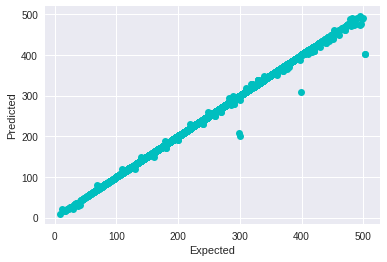

In [96]:
result = model.predict(X_test)

# predicted = [invert(x, alphabet) for x in result]
predicted = [integer_combine(decode(x)) for x in result]
expected = [integer_combine(decode(x)) for x in Y_test]

loss, acc = model.evaluate(X_test, Y_test)

print("Loss on test set: %f" % loss)
print("Accuracy on test set: %f" % acc)
# print("Mean squared error:")
mse = mean_squared_error(expected, predicted)
print('Mean squared error: %f' % mse)

# rmse = sqrt(mean_squared_error(expected, predicted))
# print('RMSE: %f' % rmse)

print("--First 20 examples result:--")
for i in range(20):
	print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))
	print('Difference=%s' % (abs(expected[i] - predicted[i])))
  
plt.plot(expected, predicted, 'oc')
plt.xlabel("Expected")
plt.ylabel("Predicted")

plt.show()

### Save model

In [0]:

model.save(SECOND_MODEL_NAME)
# for loading model:
# model = load_model('sum_digits_RNN.h5')


# Conclusions

- **In the first task, the problem of recognizing multi-digit numbers generated from the MNIST dataset with transformations was solved using a Convolutional Neural Network. The strategy for this task was to use opencv library to separate groups of points as individual digits, train the network on individual digits and then assemble the numbers from individual digits after prediction. The structure of the layers was the following: 2 Convolutional 2D layers (each one with 32 filters) and one Dense layer The accuracy on the training set was  91.29 on individual digits and on the test set was 79.68% (on individual digits) and 61.33% on full numbers**



- **The second task consisted in adding 2 numbers using a neural network. The strategy used for this task was to build an encoder-decoder model architecture (also named sequence to sequence) and predict the sum of the integers based on encoded sequences of initial numbers. The neural network consisted of 2 LSTM layers (the first with 100 cells and the second with 50) and a Dense layer.
The accuracy obtained on the training set was 99.28% and on the test set was 99.04%**

